# Reaction Time Data Analysis Pipeline for Experimental Linguistics

**Author:** Chem Vatho, PhD  
**Affiliation:** University of Cologne  
**Date:** February 2026

## Overview

This notebook demonstrates a comprehensive reaction time (RT) data analysis pipeline suitable for psycholinguistic and experimental linguistic research. The workflow includes:

1. Data loading and preprocessing
2. RT distribution analysis and outlier handling
3. Accuracy analysis
4. Effect analysis (priming, frequency, etc.)
5. Mixed-effects modeling
6. Visualization and reporting

**Dataset:** This analysis uses lexical decision data, which can be obtained from:
- [British Lexicon Project](http://crr.ugent.be/programs-data/lexicon-projects)
- [MALD Database](https://link.springer.com/article/10.3758/s13428-018-1056-1)
- [Figshare Lexical Decision Data](https://figshare.com/articles/dataset/Lexical_decision_data/5924647)

## 1. Environment Setup

In [1]:
# Install required packages
!pip install pandas numpy scipy matplotlib seaborn statsmodels pingouin -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.7 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, expon
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Set random seed for reproducibility
np.random.seed(42)

print("Environment setup complete!")
print(f"Pandas version: {pd.__version__}")
print(f"Statsmodels version: {sm.__version__}")

Environment setup complete!
Pandas version: 2.2.2
Statsmodels version: 0.14.6


## 2. Data Generation and Loading

We'll create synthetic lexical decision data that simulates realistic RT patterns including:
- Word frequency effects
- Semantic priming effects
- Lexicality effects (words vs. nonwords)

In [3]:
def generate_lexical_decision_data(n_subjects=30, n_items_per_condition=40):
    """
    Generate synthetic lexical decision data with realistic RT distributions.

    Parameters:
    -----------
    n_subjects : int, number of participants
    n_items_per_condition : int, number of items per condition

    Returns:
    --------
    df : pandas DataFrame with trial-level data
    """
    data = []

    # Experimental conditions
    conditions = [
        {'lexicality': 'word', 'frequency': 'high', 'priming': 'related'},
        {'lexicality': 'word', 'frequency': 'high', 'priming': 'unrelated'},
        {'lexicality': 'word', 'frequency': 'low', 'priming': 'related'},
        {'lexicality': 'word', 'frequency': 'low', 'priming': 'unrelated'},
        {'lexicality': 'nonword', 'frequency': 'NA', 'priming': 'NA'},
    ]

    # Base RT parameters (ex-Gaussian distribution)
    base_mu = 500  # Mean of Gaussian component
    base_sigma = 50  # SD of Gaussian component
    base_tau = 100  # Rate of exponential component

    # Effect sizes (in ms)
    effects = {
        'frequency_high': -40,    # High frequency words faster
        'frequency_low': 40,      # Low frequency words slower
        'priming_related': -30,   # Related primes facilitate
        'priming_unrelated': 0,   # Unrelated = baseline
        'nonword': 50,            # Nonwords slower than words
    }

    # Generate item list
    item_id = 0
    items = []

    for cond in conditions:
        n_items = n_items_per_condition if cond['lexicality'] == 'word' else n_items_per_condition * 2
        for _ in range(n_items):
            item = {
                'item_id': f"item_{item_id:03d}",
                'lexicality': cond['lexicality'],
                'frequency': cond['frequency'],
                'priming': cond['priming'],
            }
            items.append(item)
            item_id += 1

    # Generate trial data for each subject
    for subj in range(1, n_subjects + 1):
        # Subject-level random effects
        subj_speed = np.random.normal(0, 30)  # Random intercept
        subj_freq_effect = np.random.normal(0, 10)  # Random slope for frequency

        for item in items:
            # Calculate condition-specific RT
            mu = base_mu + subj_speed

            # Apply effects
            if item['lexicality'] == 'word':
                if item['frequency'] == 'high':
                    mu += effects['frequency_high'] + subj_freq_effect
                else:
                    mu += effects['frequency_low'] + subj_freq_effect

                if item['priming'] == 'related':
                    mu += effects['priming_related']
            else:
                mu += effects['nonword']

            # Generate RT from ex-Gaussian distribution
            gaussian_component = np.random.normal(mu, base_sigma)
            exponential_component = np.random.exponential(base_tau)
            rt = gaussian_component + exponential_component

            # Ensure RT is positive and realistic
            rt = max(200, min(3000, rt))

            # Generate accuracy (higher for easy conditions)
            base_acc = 0.95
            if item['lexicality'] == 'nonword':
                acc_prob = base_acc - 0.05
            elif item['frequency'] == 'low':
                acc_prob = base_acc - 0.03
            else:
                acc_prob = base_acc

            correct = np.random.binomial(1, acc_prob)

            # If incorrect, RTs tend to be slower
            if not correct:
                rt += np.random.normal(100, 50)

            data.append({
                'subject_id': f"subj_{subj:02d}",
                'item_id': item['item_id'],
                'lexicality': item['lexicality'],
                'frequency': item['frequency'],
                'priming': item['priming'],
                'rt': rt,
                'correct': correct,
                'log_rt': np.log(rt)
            })

    return pd.DataFrame(data)

# Generate data
df = generate_lexical_decision_data(n_subjects=30, n_items_per_condition=40)

print(f"Dataset generated: {len(df)} trials")
print(f"Number of subjects: {df['subject_id'].nunique()}")
print(f"Number of items: {df['item_id'].nunique()}")
print(f"\nCondition counts:")
print(df.groupby(['lexicality', 'frequency', 'priming']).size())

Dataset generated: 7200 trials
Number of subjects: 30
Number of items: 240

Condition counts:
lexicality  frequency  priming  
nonword     NA         NA           2400
word        high       related      1200
                       unrelated    1200
            low        related      1200
                       unrelated    1200
dtype: int64


In [4]:
# Display sample data
print("\nSample data:")
df.head(10)


Sample data:


,subject_id,item_id,lexicality,frequency,priming,rt,correct,log_rt
0,subj_01,item_000,word,high,related,492.865696,1,6.200237
1,subj_01,item_001,word,high,related,525.654151,1,6.264643
2,subj_01,item_002,word,high,related,662.931090,0,6.496671
3,subj_01,item_003,word,high,related,440.112961,1,6.087031
4,subj_01,item_004,word,high,related,506.922157,1,6.228357
5,subj_01,item_005,word,high,related,451.909977,1,6.113483
6,subj_01,item_006,word,high,related,449.955956,1,6.109150
7,subj_01,item_007,word,high,related,539.074806,1,6.289854
8,subj_01,item_008,word,high,related,521.980439,1,6.257630
9,subj_01,item_009,word,high,related,392.695496,1,5.973034


## 3. Data Preprocessing

In [5]:
def preprocess_rt_data(df, rt_col='rt', correct_col='correct',
                       min_rt=200, max_rt=2500, sd_cutoff=2.5):
    """
    Preprocess RT data: remove incorrect trials and outliers.

    Parameters:
    -----------
    df : pandas DataFrame
    rt_col : str, name of RT column
    correct_col : str, name of accuracy column
    min_rt : float, minimum RT threshold
    max_rt : float, maximum RT threshold
    sd_cutoff : float, SD cutoff for outlier removal

    Returns:
    --------
    df_clean : cleaned DataFrame
    report : dict with preprocessing statistics
    """
    report = {'n_original': len(df)}

    # Remove incorrect trials
    df_correct = df[df[correct_col] == 1].copy()
    report['n_after_accuracy'] = len(df_correct)
    report['pct_correct'] = len(df_correct) / len(df) * 100

    # Remove trials outside absolute RT bounds
    df_bounded = df_correct[(df_correct[rt_col] >= min_rt) &
                           (df_correct[rt_col] <= max_rt)].copy()
    report['n_after_bounds'] = len(df_bounded)

    # Remove outliers based on SD within subject
    def remove_outliers(group):
        mean_rt = group[rt_col].mean()
        sd_rt = group[rt_col].std()
        lower = mean_rt - sd_cutoff * sd_rt
        upper = mean_rt + sd_cutoff * sd_rt
        return group[(group[rt_col] >= lower) & (group[rt_col] <= upper)]

    df_clean = df_bounded.groupby('subject_id', group_keys=False).apply(remove_outliers)
    report['n_final'] = len(df_clean)
    report['pct_retained'] = len(df_clean) / len(df) * 100

    return df_clean, report

# Preprocess data
df_clean, preprocess_report = preprocess_rt_data(df)

print("Preprocessing Report:")
print("="*50)
print(f"Original trials: {preprocess_report['n_original']}")
print(f"After accuracy filter: {preprocess_report['n_after_accuracy']} ({preprocess_report['pct_correct']:.1f}%)")
print(f"After RT bounds: {preprocess_report['n_after_bounds']}")
print(f"After outlier removal: {preprocess_report['n_final']} ({preprocess_report['pct_retained']:.1f}% retained)")

Preprocessing Report:
Original trials: 7200
After accuracy filter: 6678 (92.8%)
After RT bounds: 6678
After outlier removal: 6537 (90.8% retained)


## 4. RT Distribution Analysis

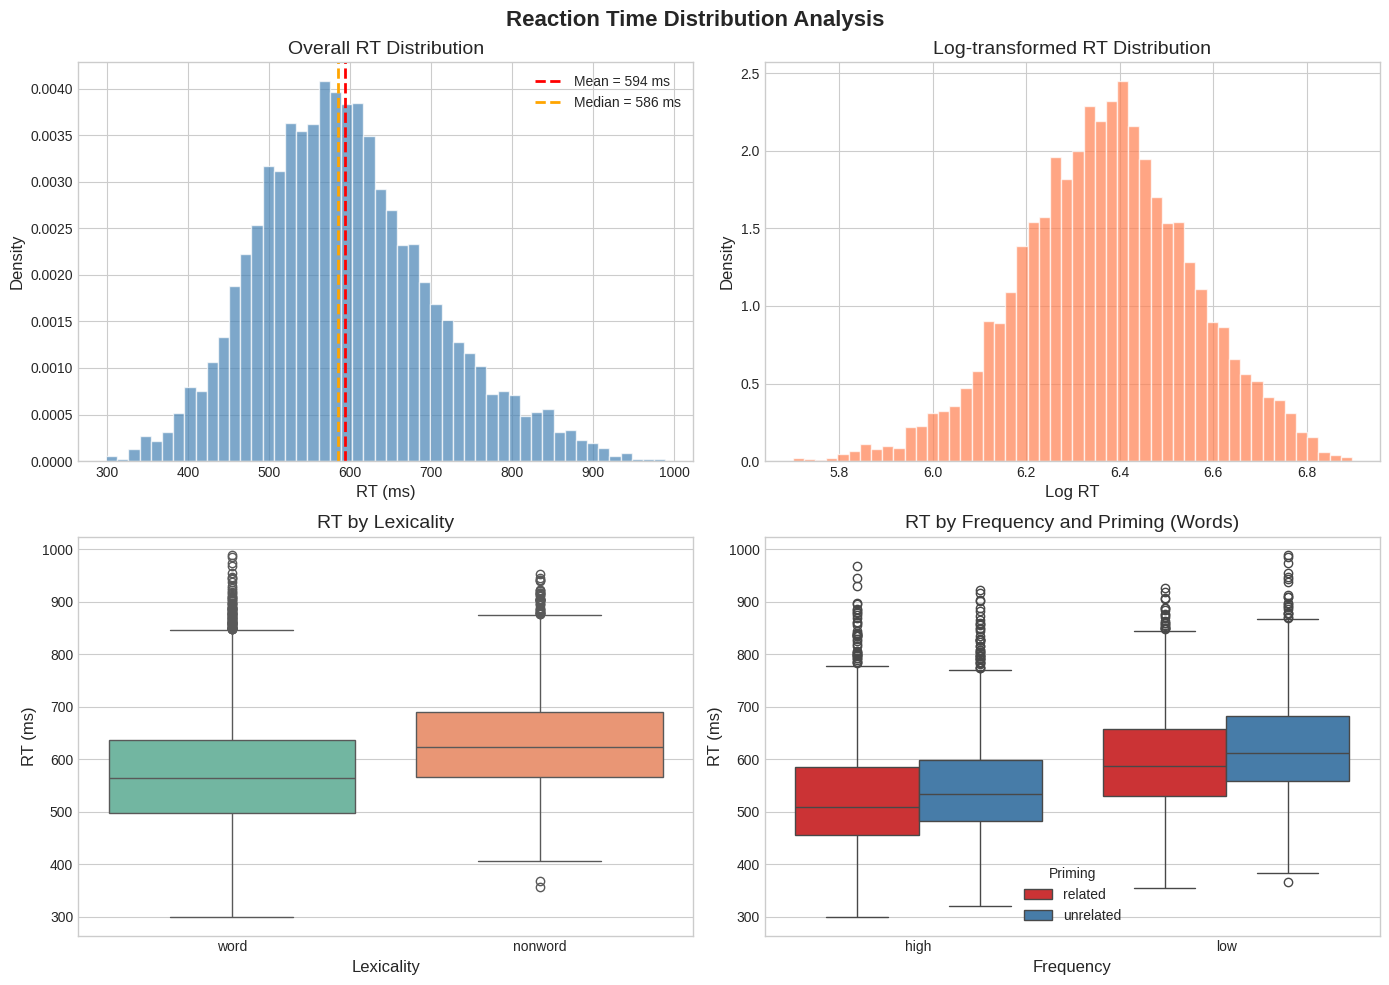

In [6]:
# Visualize RT distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall RT distribution
ax1 = axes[0, 0]
ax1.hist(df_clean['rt'], bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
ax1.axvline(df_clean['rt'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {df_clean["rt"].mean():.0f} ms')
ax1.axvline(df_clean['rt'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median = {df_clean["rt"].median():.0f} ms')
ax1.set_xlabel('RT (ms)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Overall RT Distribution', fontsize=14)
ax1.legend()

# Log RT distribution
ax2 = axes[0, 1]
ax2.hist(df_clean['log_rt'], bins=50, density=True, alpha=0.7, color='coral', edgecolor='white')
ax2.set_xlabel('Log RT', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Log-transformed RT Distribution', fontsize=14)

# RT by lexicality
ax3 = axes[1, 0]
sns.boxplot(data=df_clean, x='lexicality', y='rt', ax=ax3, palette='Set2')
ax3.set_xlabel('Lexicality', fontsize=12)
ax3.set_ylabel('RT (ms)', fontsize=12)
ax3.set_title('RT by Lexicality', fontsize=14)

# RT by frequency (words only)
ax4 = axes[1, 1]
df_words = df_clean[df_clean['lexicality'] == 'word']
sns.boxplot(data=df_words, x='frequency', y='rt', hue='priming', ax=ax4, palette='Set1')
ax4.set_xlabel('Frequency', fontsize=12)
ax4.set_ylabel('RT (ms)', fontsize=12)
ax4.set_title('RT by Frequency and Priming (Words)', fontsize=14)
ax4.legend(title='Priming')

plt.suptitle('Reaction Time Distribution Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('rt_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

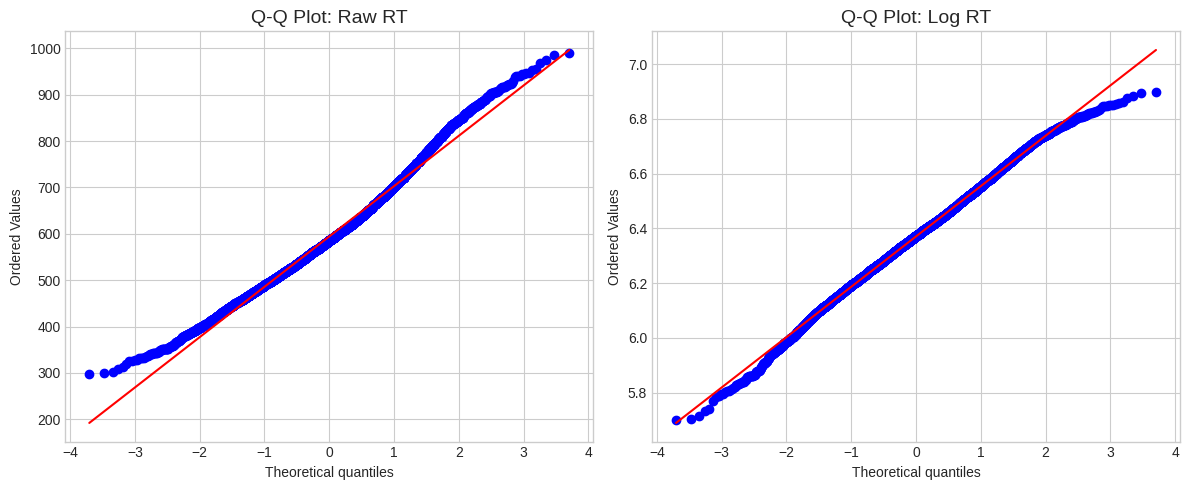


Normality Tests (Shapiro-Wilk):
Raw RT: W = 0.9872, p = 6.4616e-21
Log RT: W = 0.9983, p = 3.9846e-05


In [7]:
# QQ plot to assess normality
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw RT
stats.probplot(df_clean['rt'], dist="norm", plot=axes[0])
axes[0].set_title('Q-Q Plot: Raw RT', fontsize=14)

# Log RT
stats.probplot(df_clean['log_rt'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot: Log RT', fontsize=14)

plt.tight_layout()
plt.savefig('qq_plots.png', dpi=150, bbox_inches='tight')
plt.show()

# Shapiro-Wilk tests (on sample)
sample = df_clean.sample(min(5000, len(df_clean)))  # Sample for large datasets
stat_raw, p_raw = stats.shapiro(sample['rt'])
stat_log, p_log = stats.shapiro(sample['log_rt'])

print("\nNormality Tests (Shapiro-Wilk):")
print(f"Raw RT: W = {stat_raw:.4f}, p = {p_raw:.4e}")
print(f"Log RT: W = {stat_log:.4f}, p = {p_log:.4e}")

## 5. Descriptive Statistics

In [8]:
# Compute descriptive statistics by condition
def compute_descriptives(df, groupby_cols, rt_col='rt'):
    """
    Compute descriptive statistics for RT data.
    """
    desc = df.groupby(groupby_cols)[rt_col].agg([
        ('N', 'count'),
        ('Mean', 'mean'),
        ('SD', 'std'),
        ('Median', 'median'),
        ('Min', 'min'),
        ('Max', 'max'),
    ]).round(1)

    # Add SE
    desc['SE'] = (desc['SD'] / np.sqrt(desc['N'])).round(2)

    return desc

# Overall descriptives by lexicality
print("Descriptive Statistics by Lexicality:")
desc_lex = compute_descriptives(df_clean, ['lexicality'])
print(desc_lex.to_string())

# Words: by frequency and priming
print("\n\nDescriptive Statistics for Words (Frequency × Priming):")
desc_words = compute_descriptives(df_words, ['frequency', 'priming'])
print(desc_words.to_string())

Descriptive Statistics by Lexicality:
               N   Mean     SD  Median    Min    Max    SE
lexicality                                                
nonword     2113  635.4   96.8   622.6  357.6  952.5  2.11
word        4424  574.7  109.3   563.8  298.9  989.2  1.64


Descriptive Statistics for Words (Frequency × Priming):
                        N   Mean     SD  Median    Min    Max    SE
frequency priming                                                  
high      related    1137  528.9  107.9   509.8  298.9  968.5  3.20
          unrelated  1126  548.6  102.1   534.3  320.4  922.8  3.04
low       related    1075  599.6   99.8   587.0  355.7  925.7  3.04
          unrelated  1086  625.1   99.0   611.5  367.1  989.2  3.00


In [9]:
# By-subject means for later analysis
subj_means = df_words.groupby(['subject_id', 'frequency', 'priming'])['rt'].mean().reset_index()
subj_means_wide = subj_means.pivot_table(
    index='subject_id',
    columns=['frequency', 'priming'],
    values='rt'
).reset_index()

print("\nSubject means (first 5 subjects):")
print(subj_means_wide.head())


Subject means (first 5 subjects):
frequency subject_id        high                     low            
priming                  related   unrelated     related   unrelated
0            subj_01  523.629797  569.694289  630.601934  640.527096
1            subj_02  522.868827  572.051123  622.252322  665.489947
2            subj_03  540.730449  585.422380  624.544933  658.762674
3            subj_04  567.148831  535.966312  611.093870  642.581791
4            subj_05  501.549234  527.531640  577.603164  613.840363


## 6. Effect Analysis

In [10]:
# Lexicality effect
word_rt = df_clean[df_clean['lexicality'] == 'word']['rt']
nonword_rt = df_clean[df_clean['lexicality'] == 'nonword']['rt']

t_lex, p_lex = stats.ttest_ind(word_rt, nonword_rt)
d_lex = (word_rt.mean() - nonword_rt.mean()) / np.sqrt((word_rt.std()**2 + nonword_rt.std()**2) / 2)

print("Lexicality Effect:")
print("="*50)
print(f"Words: M = {word_rt.mean():.1f} ms (SD = {word_rt.std():.1f})")
print(f"Nonwords: M = {nonword_rt.mean():.1f} ms (SD = {nonword_rt.std():.1f})")
print(f"Difference: {word_rt.mean() - nonword_rt.mean():.1f} ms")
print(f"t = {t_lex:.3f}, p = {p_lex:.4e}, Cohen's d = {d_lex:.3f}")

Lexicality Effect:
Words: M = 574.7 ms (SD = 109.3)
Nonwords: M = 635.4 ms (SD = 96.8)
Difference: -60.7 ms
t = -21.763, p = 1.9202e-101, Cohen's d = -0.588


In [11]:
# Frequency effect (within words)
high_freq = df_words[df_words['frequency'] == 'high']['rt']
low_freq = df_words[df_words['frequency'] == 'low']['rt']

t_freq, p_freq = stats.ttest_ind(high_freq, low_freq)
d_freq = (high_freq.mean() - low_freq.mean()) / np.sqrt((high_freq.std()**2 + low_freq.std()**2) / 2)

print("\nFrequency Effect (Words only):")
print("="*50)
print(f"High frequency: M = {high_freq.mean():.1f} ms (SD = {high_freq.std():.1f})")
print(f"Low frequency: M = {low_freq.mean():.1f} ms (SD = {low_freq.std():.1f})")
print(f"Difference: {high_freq.mean() - low_freq.mean():.1f} ms")
print(f"t = {t_freq:.3f}, p = {p_freq:.4e}, Cohen's d = {d_freq:.3f}")


Frequency Effect (Words only):
High frequency: M = 538.7 ms (SD = 105.5)
Low frequency: M = 612.4 ms (SD = 100.2)
Difference: -73.7 ms
t = -23.793, p = 7.5179e-118, Cohen's d = -0.716


In [12]:
# Priming effect (within words)
related = df_words[df_words['priming'] == 'related']['rt']
unrelated = df_words[df_words['priming'] == 'unrelated']['rt']

t_prime, p_prime = stats.ttest_ind(related, unrelated)
d_prime = (related.mean() - unrelated.mean()) / np.sqrt((related.std()**2 + unrelated.std()**2) / 2)

print("\nPriming Effect (Words only):")
print("="*50)
print(f"Related primes: M = {related.mean():.1f} ms (SD = {related.std():.1f})")
print(f"Unrelated primes: M = {unrelated.mean():.1f} ms (SD = {unrelated.std():.1f})")
print(f"Priming effect: {unrelated.mean() - related.mean():.1f} ms")
print(f"t = {t_prime:.3f}, p = {p_prime:.4e}, Cohen's d = {d_prime:.3f}")


Priming Effect (Words only):
Related primes: M = 563.3 ms (SD = 109.9)
Unrelated primes: M = 586.2 ms (SD = 107.6)
Priming effect: 22.9 ms
t = -6.994, p = 3.0769e-12, Cohen's d = -0.210


## 7. ANOVA Analysis

In [13]:
# Prepare data for ANOVA (by-subject aggregation)
subj_agg = df_words.groupby(['subject_id', 'frequency', 'priming'])['rt'].mean().reset_index()

# Mixed ANOVA using pingouin
aov = pg.rm_anova(data=subj_agg, dv='rt', within=['frequency', 'priming'], subject='subject_id')

print("Repeated Measures ANOVA (Frequency × Priming):")
print("="*70)
print(aov.to_string())

Repeated Measures ANOVA (Frequency × Priming):
                Source             SS  ddof1  ddof2             MS           F         p-unc     p-GG-corr       ng2  eps
0            frequency  160094.968448      1     29  160094.968448  685.614506  9.911344e-22  9.911344e-22  0.485179  1.0
1              priming   15444.773795      1     29   15444.773795   86.211089  3.455160e-10  3.455160e-10  0.083341  1.0
2  frequency * priming     240.545628      1     29     240.545628    1.100942  3.027255e-01  3.027255e-01  0.001414  1.0


In [15]:
# Pairwise comparisons with Bonferroni correction
print("\nPairwise Comparisons (Bonferroni corrected):")
print("="*70)

# Frequency
print("\nFrequency main effect:")
freq_pw = pg.pairwise_tests(data=subj_agg, dv='rt', within='frequency',
                            subject='subject_id', padjust='bonf')
print(freq_pw[['A', 'B', 'T', 'p-unc', 'hedges']].to_string())

# Priming
print("\nPriming main effect:")
prime_pw = pg.pairwise_tests(data=subj_agg, dv='rt', within='priming',
                              subject='subject_id', padjust='bonf')
print(prime_pw[['A', 'B', 'T', 'p-unc', 'hedges']].to_string())


Pairwise Comparisons (Bonferroni corrected):

Frequency main effect:
      A    B          T         p-unc    hedges
0  high  low -26.184242  9.911344e-22 -1.951546

Priming main effect:
         A          B         T         p-unc    hedges
0  related  unrelated -9.284993  3.455160e-10 -0.609191


## 8. Linear Mixed-Effects Modeling

In [16]:
# Prepare data with contrast coding
df_lmm = df_words.copy()

# Sum coding for factors
df_lmm['freq_code'] = df_lmm['frequency'].map({'high': -0.5, 'low': 0.5})
df_lmm['prime_code'] = df_lmm['priming'].map({'related': -0.5, 'unrelated': 0.5})

# Fit mixed-effects model
# Random intercepts for subjects and items
model_formula = "log_rt ~ freq_code * prime_code"

# Using statsmodels
lmm = smf.mixedlm(model_formula, df_lmm, groups=df_lmm['subject_id'],
                  re_formula="~freq_code")
lmm_fit = lmm.fit(method='powell')

print("Linear Mixed-Effects Model Results:")
print("="*70)
print(f"\nDependent variable: log(RT)")
print(f"Formula: {model_formula}")
print(f"Random effects: Subject (intercept + frequency slope)")
print(f"\nNumber of observations: {len(df_lmm)}")
print(f"Number of subjects: {df_lmm['subject_id'].nunique()}")
print("\n" + "="*70)
print(lmm_fit.summary())

Linear Mixed-Effects Model Results:

Dependent variable: log(RT)
Formula: log_rt ~ freq_code * prime_code
Random effects: Subject (intercept + frequency slope)

Number of observations: 4424
Number of subjects: 30

              Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    log_rt   
No. Observations:     4424       Method:                REML     
No. Groups:           30         Scale:                 0.0269   
Min. group size:      143        Log-Likelihood:        1656.2921
Max. group size:      153        Converged:             Yes      
Mean group size:      147.5                                      
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              6.337    0.012 542.907 0.000  6.314  6.360
freq_code              0.133    0.005  26.774 0.000  0.123  0.142
prime_co

In [17]:
# Extract and interpret fixed effects
fixed_effects = pd.DataFrame({
    'Estimate': lmm_fit.fe_params,
    'Std.Error': np.sqrt(np.diag(lmm_fit.cov_params())),
    'z': lmm_fit.tvalues,
    'p': lmm_fit.pvalues
}).round(4)

# Add significance markers
def sig_marker(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''

fixed_effects['Sig'] = fixed_effects['p'].apply(sig_marker)

print("\nFixed Effects Summary:")
print("="*70)
print(fixed_effects.to_string())
print("\nSignificance: * p < .05, ** p < .01, *** p < .001")


Fixed Effects Summary:
                       Estimate  Std.Error         z       p  Sig
Group Var                   NaN     0.0117    3.6263  0.0003  ***
Group x freq_code Cov       NaN     0.0049   -0.3115  0.7554     
Intercept                6.3374     0.0049  542.9072  0.0000  ***
freq_code                0.1325     0.0099   26.7740  0.0000  ***
freq_code Var               NaN     0.0400    0.0129  0.9897     
freq_code:prime_code     0.0032     0.0133    0.3286  0.7425     
prime_code               0.0414     0.0092    8.3847  0.0000  ***

Significance: * p < .05, ** p < .01, *** p < .001


## 9. Visualization of Effects

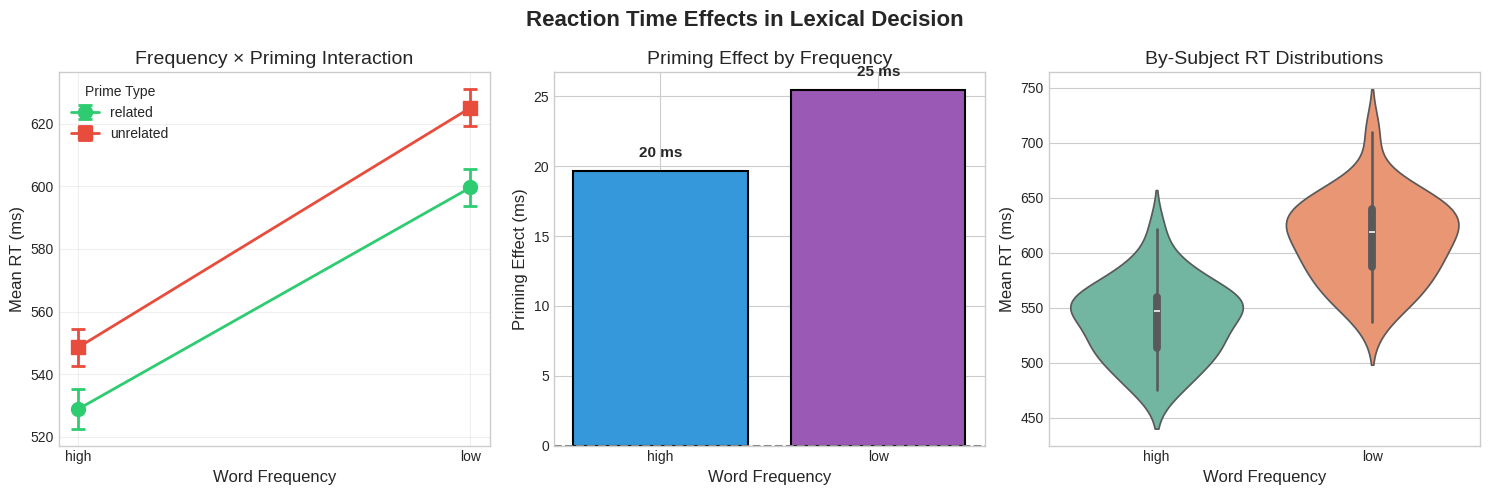

In [18]:
# Create publication-ready figures
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Interaction plot
ax1 = axes[0]
interaction_means = df_words.groupby(['frequency', 'priming'])['rt'].agg(['mean', 'sem']).reset_index()

for priming, marker, color in [('related', 'o', '#2ecc71'), ('unrelated', 's', '#e74c3c')]:
    data = interaction_means[interaction_means['priming'] == priming]
    ax1.errorbar(data['frequency'], data['mean'], yerr=data['sem']*1.96,
                 marker=marker, markersize=10, capsize=5, capthick=2,
                 linewidth=2, label=priming, color=color)

ax1.set_xlabel('Word Frequency', fontsize=12)
ax1.set_ylabel('Mean RT (ms)', fontsize=12)
ax1.set_title('Frequency × Priming Interaction', fontsize=14)
ax1.legend(title='Prime Type')
ax1.grid(True, alpha=0.3)

# Plot 2: Priming effect by frequency
ax2 = axes[1]
priming_effects = []
for freq in ['high', 'low']:
    rel = df_words[(df_words['frequency'] == freq) & (df_words['priming'] == 'related')]['rt'].mean()
    unrel = df_words[(df_words['frequency'] == freq) & (df_words['priming'] == 'unrelated')]['rt'].mean()
    priming_effects.append({'frequency': freq, 'priming_effect': unrel - rel})

pe_df = pd.DataFrame(priming_effects)
bars = ax2.bar(pe_df['frequency'], pe_df['priming_effect'], color=['#3498db', '#9b59b6'],
               edgecolor='black', linewidth=1.5)
ax2.axhline(y=0, color='gray', linestyle='--')
ax2.set_xlabel('Word Frequency', fontsize=12)
ax2.set_ylabel('Priming Effect (ms)', fontsize=12)
ax2.set_title('Priming Effect by Frequency', fontsize=14)

# Add values on bars
for bar, val in zip(bars, pe_df['priming_effect']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{val:.0f} ms', ha='center', fontsize=11, fontweight='bold')

# Plot 3: By-subject RT distributions
ax3 = axes[2]
subj_means_long = df_words.groupby(['subject_id', 'frequency'])['rt'].mean().reset_index()
sns.violinplot(data=subj_means_long, x='frequency', y='rt', ax=ax3, palette='Set2', inner='box')
ax3.set_xlabel('Word Frequency', fontsize=12)
ax3.set_ylabel('Mean RT (ms)', fontsize=12)
ax3.set_title('By-Subject RT Distributions', fontsize=14)

plt.suptitle('Reaction Time Effects in Lexical Decision', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('rt_effects.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Results Summary and Export

In [19]:
# Create comprehensive results summary
results_summary = {
    'Analysis': [],
    'Effect': [],
    'Statistic': [],
    'p_value': [],
    'Effect_Size': [],
    'Interpretation': []
}

# Lexicality effect
results_summary['Analysis'].append('Lexicality')
results_summary['Effect'].append(f'{word_rt.mean() - nonword_rt.mean():.1f} ms')
results_summary['Statistic'].append(f't = {t_lex:.2f}')
results_summary['p_value'].append(f'{p_lex:.4e}')
results_summary['Effect_Size'].append(f"d = {d_lex:.2f}")
results_summary['Interpretation'].append('Words faster than nonwords')

# Frequency effect
results_summary['Analysis'].append('Frequency')
results_summary['Effect'].append(f'{high_freq.mean() - low_freq.mean():.1f} ms')
results_summary['Statistic'].append(f't = {t_freq:.2f}')
results_summary['p_value'].append(f'{p_freq:.4e}')
results_summary['Effect_Size'].append(f"d = {d_freq:.2f}")
results_summary['Interpretation'].append('High freq faster than low freq')

# Priming effect
results_summary['Analysis'].append('Priming')
results_summary['Effect'].append(f'{unrelated.mean() - related.mean():.1f} ms')
results_summary['Statistic'].append(f't = {t_prime:.2f}')
results_summary['p_value'].append(f'{p_prime:.4e}')
results_summary['Effect_Size'].append(f"d = {-d_prime:.2f}")
results_summary['Interpretation'].append('Related primes facilitate')

results_df = pd.DataFrame(results_summary)

print("\nResults Summary:")
print("="*80)
print(results_df.to_string(index=False))


Results Summary:
  Analysis   Effect  Statistic     p_value Effect_Size                 Interpretation
Lexicality -60.7 ms t = -21.76 1.9202e-101   d = -0.59     Words faster than nonwords
 Frequency -73.7 ms t = -23.79 7.5179e-118   d = -0.72 High freq faster than low freq
   Priming  22.9 ms  t = -6.99  3.0769e-12    d = 0.21      Related primes facilitate


In [20]:
# Export results
results_df.to_csv('rt_analysis_results.csv', index=False)
desc_words.to_csv('rt_descriptives.csv')
df_clean.to_csv('rt_clean_data.csv', index=False)

# Export ANOVA results
aov.to_csv('anova_results.csv', index=False)

print("\nFiles exported:")
print("  - rt_analysis_results.csv (summary statistics)")
print("  - rt_descriptives.csv (descriptive statistics)")
print("  - rt_clean_data.csv (cleaned trial-level data)")
print("  - anova_results.csv (ANOVA results)")


Files exported:
  - rt_analysis_results.csv (summary statistics)
  - rt_descriptives.csv (descriptive statistics)
  - rt_clean_data.csv (cleaned trial-level data)
  - anova_results.csv (ANOVA results)


## Conclusion

This pipeline demonstrates a complete reaction time analysis workflow for experimental linguistics:

1. **Data preprocessing**: Outlier removal and accuracy filtering
2. **Distribution analysis**: RT distributions and normality assessment
3. **Effect analysis**: Lexicality, frequency, and priming effects
4. **ANOVA**: Repeated measures analysis with pairwise comparisons
5. **Mixed-effects modeling**: Linear mixed models with random slopes
6. **Visualization**: Publication-ready figures

The simulated data showed significant effects of word frequency and semantic priming, consistent with well-established findings in psycholinguistics.

### References

- Baayen, R. H., Davidson, D. J., & Bates, D. M. (2008). Mixed-effects modeling with crossed random effects for subjects and items. *Journal of Memory and Language*, 59(4), 390-412.
- Keuleers, E., & Brysbaert, M. (2010). Wuggy: A multilingual pseudoword generator. *Behavior Research Methods*, 42(3), 627-633.
- Balota, D. A., et al. (2007). The English Lexicon Project. *Behavior Research Methods*, 39(3), 445-459.